## 1 Preliminaries

## 1.1 Imports and Configurations

### Imports

In [1]:
!pip install -q transformers[torch] evaluate rouge_score

In [2]:
import os
import warnings
import json
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision
import evaluate
import requests
import random

from copy import deepcopy
from tqdm import tqdm
from torchvision.io import read_image
from torch.utils.data import DataLoader
from transformers import ViltConfig, ViltProcessor, ViltForQuestionAnswering, Trainer, TrainingArguments, DataCollatorWithPadding, EarlyStoppingCallback
from PIL import Image

### Constants

In [3]:
RANDOM_STATE = 42

RAW_DATA_DIR = '/content/drive/MyDrive/binary-vqa-example/data/raw/'

VQA_PATH = RAW_DATA_DIR + 'VQA_train.csv'
ANNOTATIONS_PATH = RAW_DATA_DIR + 'abstract_v002_train2017_annotations.json'
QUESTIONS_PATH = RAW_DATA_DIR + 'OpenEnded_abstract_v002_train2017_questions.json'
IMG_DIR = RAW_DATA_DIR + 'scene_img_abstract_v002_train2017/'

IMG_PREFIX = 'abstract_v002_train2015_'
IMG_FORMAT = '.png'

VILT_B32_PRETRAINED = 'dandelin/vilt-b32-finetuned-vqa'

MODELS_DIR = '/content/drive/MyDrive/binary-vqa-example/models/'
OVERWRITE_OUTPUT_DIR = True
EVALUATION_STRATEGY = 'steps'
EVAL_STEPS = 500
LOGGING_STRATEGY = 'steps'
LOGGING_STEPS = 500
SAVE_STRATEGY = 'steps'
SAVE_STEPS = 500
SAVE_TOTAL_LIMIT = 2
LEARNING_RATE = 5e-5
BATCH_SIZE = 8
NUM_TRAIN_EPOCHS = 10.0
LOAD_BEST_MODEL_AT_END = True
REPORT_TO = 'none'
EARLY_STOPPING_PATIENCE = 3

### Configs

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
warnings.filterwarnings('ignore')

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cpu


## 1.2 Fast EDA

In [7]:
vqa_data = pd.read_csv(VQA_PATH, index_col=0)

with open(ANNOTATIONS_PATH) as f:
    annotations = json.load(f)['annotations']

with open(QUESTIONS_PATH) as f:
    questions = json.load(f)['questions']

### VQA

In [8]:
vqa_data.head()

,image_id,question,question_id,answer
0,87,Is the boy having wine?,870,yes
1,900000870,Is the boy having wine?,900000870,no
2,14962,Is it night time?,149620,no
3,900149620,Is it night time?,900149620,yes
4,8277,Is the boy hanging from monkey bars?,82771,yes


In [9]:
vqa_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22055 entries, 0 to 22054
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_id     22055 non-null  int64 
 1   question     22055 non-null  object
 2   question_id  22055 non-null  int64 
 3   answer       22055 non-null  object
dtypes: int64(2), object(2)
memory usage: 861.5+ KB


In [10]:
print(f'N unique: {vqa_data["image_id"].nunique()}')
print(f'N Values > 1: {(vqa_data["image_id"].value_counts() > 1).sum()}')

N unique: 20629
N Values > 1: 1357


In [11]:
print(f'N unique: {vqa_data["question"].nunique()}')
print(f'N Values > 1: {(vqa_data["question"].value_counts() > 1).sum()}')

N unique: 9471
N Values > 1: 8394


In [12]:
print(f'N unique: {vqa_data["question_id"].nunique()}')
print(f'N Values > 1: {(vqa_data["question_id"].value_counts() > 1).sum()}')

N unique: 22055
N Values > 1: 0


In [13]:
print(f'N unique: {vqa_data["answer"].nunique()}')
print(f'N Values > 1: {(vqa_data["answer"].value_counts() > 1).sum()}')

no_count, yes_count = vqa_data["answer"].value_counts()
print(f'N no: {no_count}, N yes: {yes_count}')

N unique: 2
N Values > 1: 2
N no: 11240, N yes: 10815


### Annotations

In [14]:
annotations[12]

{'question_type': 'is the boy',
 'multiple_choice_answer': 'yes',
 'answers': [{'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 1},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'no', 'answer_confidence': 'maybe', 'answer_id': 3},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 7},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 16397,
 'answer_type': 'yes/no',
 'question_id': 163971}

### Questions

In [15]:
questions[12]

{'image_id': 16397,
 'question': 'Is the boy waving to the girl?',
 'question_id': 163971}

### Images

In [16]:
def show_img(vqa_data, img_dir, img_name, img_id):
    img = mpimg.imread(os.path.join(img_dir, img_name))
    question, answer = vqa_data.loc[vqa_data['image_id'] == img_id, ['question', 'answer']].values[0]

    plt.title(f'{question} - {answer}')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    print(f'Image shape: {img.shape}')

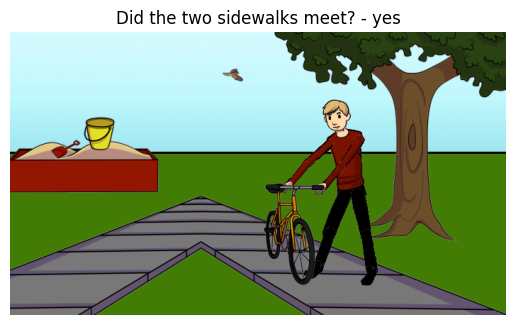

Image shape: (400, 700, 4)


In [17]:
show_img(vqa_data, IMG_DIR, 'abstract_v002_train2015_000000000389.png', 389)

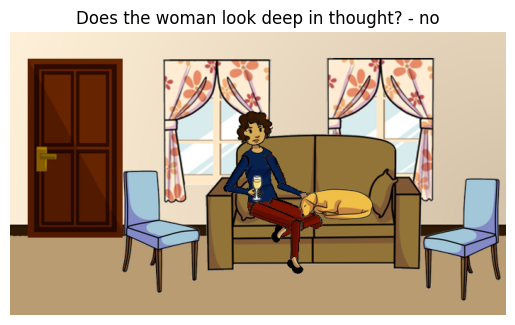

Image shape: (400, 700, 4)


In [18]:
show_img(vqa_data, IMG_DIR, 'abstract_v002_train2015_000900172021.png', 900172021)

## 2 Data Preprocessing

## 2.1 VQA Dataset

### Lowercase

In [19]:
def to_lowercase(vqa_data):
    X = vqa_data.copy()
    X[['question', 'answer']].apply(lambda x: x.str.lower(), axis=0)
    return X

In [20]:
vqa_data = to_lowercase(vqa_data)

### Image Paths

In [21]:
def add_img_paths(vqa_data, prefix, format='.png'):
    X = vqa_data.copy()
    X['image_path'] = \
        prefix + \
        (12 - vqa_data['image_id'].astype('str').str.len()).apply(lambda x: x * '0') + \
    vqa_data['image_id'].astype('str') + format
    return X

In [22]:
vqa_data = add_img_paths(vqa_data, IMG_PREFIX, IMG_FORMAT)

### Add Labels and Scores

In [23]:
def get_score(count):
    return min(1.0, count / 3)

In [24]:
def add_labels_and_scores(vqa_data, annotations, config):
    X = vqa_data.copy()
    X['labels'] = np.nan
    X['scores'] = np.nan

    for annotation in tqdm(annotations):
        answers = annotation['answers']
        answer_count = {}

        for answer in answers:
            answer_count[answer['answer']] = answer_count.get(answer['answer'], 0) + 1

        labels = []
        scores = []

        for answer in answer_count:
            if answer not in list(config.label2id.keys()):
                continue
            labels.append(config.label2id[answer])
            score = get_score(answer_count[answer])
            scores.append(score)

            X.loc[X['question_id'] == annotation['question_id'], 'labels'] = X.loc[X['question_id'] == annotation['question_id'], 'labels'].apply(lambda x: labels)
            X.loc[X['question_id'] == annotation['question_id'], 'scores'] = X.loc[X['question_id'] == annotation['question_id'], 'scores'].apply(lambda x: scores)

    return X

In [25]:
vilt_config = ViltConfig.from_pretrained(VILT_B32_PRETRAINED)

In [26]:
vqa_data = add_labels_and_scores(vqa_data, annotations, vilt_config)

100%|██████████| 22055/22055 [01:41<00:00, 217.38it/s]


In [27]:
vqa_data.head()

,image_id,question,question_id,answer,image_path,labels,scores
0,87,Is the boy having wine?,870,yes,abstract_v002_train2015_000000000087.png,"[9, 3]","[0.3333333333333333, 1.0]"
1,900000870,Is the boy having wine?,900000870,no,abstract_v002_train2015_000900000870.png,[9],[1.0]
2,14962,Is it night time?,149620,no,abstract_v002_train2015_000000014962.png,[9],[1.0]
3,900149620,Is it night time?,900149620,yes,abstract_v002_train2015_000900149620.png,[3],[1.0]
4,8277,Is the boy hanging from monkey bars?,82771,yes,abstract_v002_train2015_000000008277.png,[3],[1.0]


## 2.2 Loaders

### ViLT-b32 Loaders

In [28]:
class ViltDataset(torch.utils.data.Dataset):

    def __init__(self, data, config, processor, img_dir, max_length=32):
        self.data = data
        self.config = config
        self.processor = processor
        self.max_length = max_length
        self.img_dir = img_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.loc[idx, ['question', 'image_path', 'labels', 'scores']]

        img = read_image(self.img_dir + str(item['image_path']))[:3,:,:]

        encoding = self.processor(
            img,
            item['question'],
            max_length=self.max_length,
            truncation=True,
            return_tensors='pt',
        )

        for k, v in encoding.items():
            encoding[k] = v.squeeze()

        targets = torch.zeros(len(self.config.id2label))
        for label, score in zip(item['labels'], item['scores']):
              targets[label] = score
        encoding['labels'] = targets

        return encoding

In [29]:
vilt_processor = ViltProcessor.from_pretrained(VILT_B32_PRETRAINED)

In [30]:
vilt_ds = ViltDataset(vqa_data, vilt_config, vilt_processor, IMG_DIR)
vilt_train_ds, vilt_val_ds, vilt_test_ds = torch.utils.data.random_split(vilt_ds, [15439, 3308, 3308])

### BLIP Loaders

In [31]:
# class BlipDataset(torch.utils.data.Dataset):

#     def __init__(self, data, processor, img_dir, max_length=32):
#         self.data = data
#         self.processor = processor
#         self.max_length = max_length
#         self.img_dir = img_dir

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         item = self.data.loc[idx, ['question', 'answer', 'image_path']]

#         img = read_image(self.img_dir + str(item['image_path']))[:3,:,:]

#         encoding = self.processor(
#             img,
#             item['question'],
#             max_length=self.max_length,
#             truncation=True,
#             return_tensors='pt',
#         )

#         encoding['label'] = self.processor.tokenizer.encode(
#             item['answer'],
#             max_length=self.max_length,
#             truncation=True,
#             return_tensors='pt',
#         )

#         for k, v in encoding.items():
#             encoding[k] = v.squeeze()

#         return encoding

### Metrics

## 3 Building Models

## 3.1 VILT-b32

In [ ]:
vilt_model = ViltForQuestionAnswering.from_pretrained(VILT_B32_PRETRAINED, id2label=vilt_config.id2label, label2id=vilt_config.label2id)
vilt_model.to(device)

ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

In [ ]:
vilt_args = TrainingArguments(
    output_dir=MODELS_DIR,
    overwrite_output_dir=OVERWRITE_OUTPUT_DIR,
    evaluation_strategy=EVALUATION_STRATEGY,
    eval_steps=EVAL_STEPS,
    logging_strategy=LOGGING_STRATEGY,
    logging_steps=LOGGING_STEPS,
    save_strategy=SAVE_STRATEGY,
    save_steps=SAVE_STEPS,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    save_total_limit=SAVE_TOTAL_LIMIT,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    load_best_model_at_end=LOAD_BEST_MODEL_AT_END,
    report_to=REPORT_TO,
)

In [ ]:
vilt_collator = DataCollatorWithPadding(vilt_processor.tokenizer)

vilt_trainer = Trainer(
    vilt_model,
    vilt_args,
    train_dataset=vilt_train_ds,
    eval_dataset=vilt_val_ds,
    data_collator=vilt_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING_PATIENCE)]
)

In [ ]:
vilt_trainer.train()

## 4 Evaluating Models

## 4.1 VILT-b32

In [32]:
finetunned_vilt_model = ViltForQuestionAnswering.from_pretrained(
    MODELS_DIR + 'vilt-b32-finetunned/',
    id2label=vilt_config.id2label,
    label2id=vilt_config.label2id
).to(device)

vilt_processor = ViltProcessor.from_pretrained(VILT_B32_PRETRAINED)
vilt_collator = DataCollatorWithPadding(vilt_processor.tokenizer)

### Evaluating Test Dataset

In [33]:
def calculate_metric_on_test_ds(model, processor, test_dl, metric, device):
    for batch in tqdm(test_dl):
        batch = batch.to(device)
        labels = batch['labels']
        batch.pop('labels', None)

        outputs = model(**batch)
        logits = outputs.logits

        input_idxs = [logit.argmax(-1).item() for logit in logits]
        label_idxs = [label.argmax(-1).item()for label in labels]
        preds = [model.config.id2label[input_idx] for input_idx in input_idxs]
        refs = [model.config.id2label[label_idx] for label_idx in label_idxs]

        metric.add_batch(predictions=preds, references=refs)

    return metric.compute()

In [34]:
rouge_metric = evaluate.load('rouge')

vilt_test_dl = DataLoader(
    vilt_test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=vilt_collator,
)

In [35]:
rouge_score = calculate_metric_on_test_ds(finetunned_vilt_model, vilt_processor, vilt_test_dl, rouge_metric, device)
print(f'ROUGE: {rouge_score}')

100%|██████████| 414/414 [1:13:32<00:00, 10.66s/it]


ROUGE: {'rouge1': 0.6194074969770254, 'rouge2': 0.0, 'rougeL': 0.6188029020556227, 'rougeLsum': 0.6188029020556227}


### Inference

In [36]:
def get_image(url):
  return Image.open(requests.get(url, stream=True).raw)

In [37]:
def get_answer(model, processor, device, image, question):
    encoding = processor(image, question.lower(), return_tensors='pt').to(device)
    outputs = model(**encoding)
    logits = outputs.logits
    idx = logits.argmax(-1).item()
    return model.config.id2label[idx]

In [38]:
example_img_url_1 = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQJkiuW0eCmh2n2Og_n0d0hP-XOFoEu3aVUygRFIPU1SUe2-vSS'
example_img_url_2 = 'https://encrypted-tbn2.gstatic.com/images?q=tbn:ANd9GcTWXMtSpvpjRqhhdyx0eLczvUH9axhMTUbSEkznTKSrOcnaBqZO'
example_img_url_3 = 'https://encrypted-tbn2.gstatic.com/images?q=tbn:ANd9GcSd5Vy-f-CWlBir623ru8yXwDWm6rlKsRofepQGua1fj1UgtiRh'

In [39]:
print(get_answer(finetunned_vilt_model, vilt_processor, device, get_image(example_img_url_1), 'are there any people?'))
print(get_answer(finetunned_vilt_model, vilt_processor, device, get_image(example_img_url_1), 'is it rainy here?'))

no
no


In [40]:
print(get_answer(finetunned_vilt_model, vilt_processor, device, get_image(example_img_url_2), 'are there trees?'))
print(get_answer(finetunned_vilt_model, vilt_processor, device, get_image(example_img_url_2), 'are there any people?'))
print(get_answer(finetunned_vilt_model, vilt_processor, device, get_image(example_img_url_2), 'is it cloudy here?'))

yes
yes
yes


In [41]:
print(get_answer(finetunned_vilt_model, vilt_processor, device, get_image(example_img_url_3), 'is a man carrying something on a cart?'))
print(get_answer(finetunned_vilt_model, vilt_processor, device, get_image(example_img_url_3), 'is it rainy here?'))
print(get_answer(finetunned_vilt_model, vilt_processor, device, get_image(example_img_url_3), 'is there a sun?'))
print(get_answer(finetunned_vilt_model, vilt_processor, device, get_image(example_img_url_3), 'are there any animals?'))

yes
no
yes
no


In [43]:
example_sample_1 = vqa_data.sample(1)
example_sample_1

,image_id,question,question_id,answer,image_path,labels,scores
6016,900186552,Is the dog having fun with the girl?,900186552,no,abstract_v002_train2015_000900186552.png,[9],[1.0]


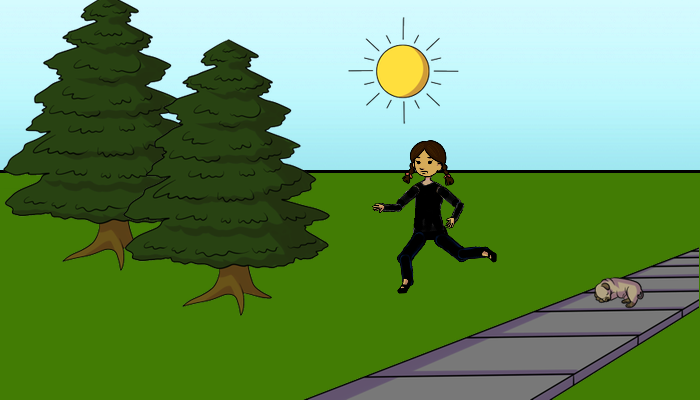

In [44]:
example_img_1 = Image.open(IMG_DIR + 'abstract_v002_train2015_000900186552.png').convert('RGB')
example_img_1

In [56]:
print(get_answer(finetunned_vilt_model, vilt_processor, device, example_img_1, 'Is the dog having fun with the girl?'))
print(get_answer(finetunned_vilt_model, vilt_processor, device, example_img_1, 'Is the girl running?'))
print(get_answer(finetunned_vilt_model, vilt_processor, device, example_img_1, 'Girl walking on the ground?'))
print(get_answer(finetunned_vilt_model, vilt_processor, device, example_img_1, 'Are there any trees?'))
print(get_answer(finetunned_vilt_model, vilt_processor, device, example_img_1, 'is there a sun?'))
print(get_answer(finetunned_vilt_model, vilt_processor, device, example_img_1, 'Are there any pets?'))
print(get_answer(finetunned_vilt_model, vilt_processor, device, example_img_1, 'Are there any cats?'))
print(get_answer(finetunned_vilt_model, vilt_processor, device, example_img_1, 'Is the dog lying on the road?'))
print(get_answer(finetunned_vilt_model, vilt_processor, device, example_img_1, 'Is the dog black?'))

no
no
yes
yes
yes
yes
yes
no
no
